In [1]:
import os
import os.path
import random
import csv
import sys
import numpy as np
import tensorflow as tf
%matplotlib inline
import PIL.Image
import numpy as np
from libs import dataset_utils as datasets
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage import data
from scipy.misc import imresize
import IPython.display as ipyd

## Parameters

1. Thumbnail size - parameter "size"
2. Latent vector dimensionality - parameter "latent_dim"
3. Hidden dimensionality, i.e., number of neurons - parameter "h_dim"
4. Number of iterations
5. Image preprocessing (Binarizing, normalizing etc.)
6. Optimizer type - Adam, Adadelta, GradientDescentOptimizer, AdagradOptimizer etc..
7. Batch size

In [2]:
def csv_to_dict(csv_path):
    with open(csv_path,'r') as fp:
        csv_fp=csv.reader(fp)
        next(csv_fp)
        d = dict(filter(None, csv_fp))
        return d

def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def FC_layer(X, W, b):
    return tf.matmul(X, W) + b

In [4]:
data_path="/home/intergalactic/cosmology_aux_data_170429"

# Paths
labeled_path=os.path.join(data_path,"labeled")
label_file=os.path.join(data_path,"labeled.csv")

# Initialization
label_dict=csv_to_dict(label_file)
# Get list of image prefixes
img_prefixes=list(label_dict.keys())
# Get all galaxy images
img_prefixes_galaxy = dict((k, v) for k, v in label_dict.items() if float(v)==1.0)
img_prefixes_galaxy_keys = list(img_prefixes_galaxy.keys())
len(img_prefixes_galaxy)

# Encoder Input
size = 128,128
n_pixels = size[0]*size[1]
# First layer placeholder
X = tf.placeholder(tf.float32, shape=([None, n_pixels]))

In [5]:
# Load scored images, galaxy images with a score > 3.0

s_labeled_path=os.path.join(data_path,"scored")
s_label_file=os.path.join(data_path,"scored.csv")
s_label_dict=csv_to_dict(s_label_file)
s_img_prefixes=list(s_label_dict.keys())
s_img_prefixes_galaxy = dict((k, v) for k, v in s_label_dict.items() if float(v)>3.0)
s_img_prefixes_galaxy_keys = list(s_img_prefixes_galaxy.keys())
len(s_img_prefixes_galaxy)

1165

In [7]:
# Numpy array that will hold our images
data = np.ndarray(shape=(len(img_prefixes_galaxy) + len(s_img_prefixes_galaxy),size[0]*size[1]), order='F')
# To store the last index before loading scored images into the same array
tmp = 0
for idx,img_prefix in enumerate(img_prefixes_galaxy):
    img_prefix=img_prefixes_galaxy_keys[idx]
    print("Loading image {} : {}/{}".format(img_prefix,idx+1,len(img_prefixes_galaxy)))
    print(os.path.join(labeled_path,"{}.png".format(img_prefix)))
    # Load labeled Image
    raw_image=PIL.Image.open(os.path.join(labeled_path,"{}.png".format(img_prefix)))
    print("Raw size 0 = {} Raw size 1 = {}".format(raw_image.size[0],raw_image.size[1]))
    # Downsize image
    raw_image.thumbnail(size, PIL.Image.LANCZOS)
    img_arr=np.ravel(np.asarray(raw_image,dtype=np.uint8))
    # Flatten and load image into array
    data[idx] = img_arr
    tmp = idx
    
# Repeat for scored images
tmp += 1
for s_idx in range(len(s_img_prefixes_galaxy)):
    s_img_prefix=s_img_prefixes_galaxy_keys[idx]
    print("Loading scored image {} : {}/{}".format(s_img_prefix,s_idx+1,len(s_img_prefixes_galaxy)))
    print(os.path.join(s_labeled_path,"{}.png".format(s_img_prefix)))
    s_raw_image=PIL.Image.open(os.path.join(s_labeled_path,"{}.png".format(s_img_prefix)))
    print("Raw size 0 = {} Raw size 1 = {}".format(s_raw_image.size[0],s_raw_image.size[1]))
    s_raw_image.thumbnail(size, PIL.Image.LANCZOS)
    #raw_image.save("/home/intergalactic/Prashanth/label_true_thumbnails/{}.png".format(img_prefix))
    s_img_arr=np.ravel(np.asarray(s_raw_image,dtype=np.uint8))
    data[tmp] = s_img_arr
    tmp += 1

Loading image 5939498 : 1/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\5939498.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 5283916 : 2/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\5283916.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 7077153 : 3/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\7077153.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 7593920 : 4/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\7593920.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 7708730 : 5/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\7708730.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 6451940 : 6/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\6451940.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 4740414 : 7/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_da

Raw size 0 = 1000 Raw size 1 = 1000
Loading image 8038496 : 56/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\8038496.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 2159625 : 57/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\2159625.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 3070190 : 58/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\3070190.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 7745502 : 59/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\7745502.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 1233495 : 60/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\1233495.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 3635005 : 61/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\3635005.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 7121971 : 62/1000
D:\ETH\E

Loading image 7899247 : 110/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\7899247.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 9760653 : 111/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\9760653.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 5022989 : 112/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\5022989.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 3901333 : 113/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\3901333.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 4965837 : 114/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\4965837.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 1449363 : 115/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\1449363.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 4826647 : 116/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\co

Raw size 0 = 1000 Raw size 1 = 1000
Loading image 8316271 : 166/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\8316271.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 1256104 : 167/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\1256104.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 4090902 : 168/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\4090902.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 1909169 : 169/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\1909169.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 2915128 : 170/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\2915128.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 3126755 : 171/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\3126755.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 7197494 : 172/1000
D

Raw size 0 = 1000 Raw size 1 = 1000
Loading image 5776882 : 220/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\5776882.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 7303199 : 221/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\7303199.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 4587470 : 222/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\4587470.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 1775228 : 223/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\1775228.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 2328056 : 224/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\2328056.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 1104845 : 225/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\1104845.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 9285275 : 226/1000
D

Raw size 0 = 1000 Raw size 1 = 1000
Loading image 5016808 : 277/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\5016808.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 9650126 : 278/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\9650126.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 4433861 : 279/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\4433861.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 2478432 : 280/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\2478432.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 5095557 : 281/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\5095557.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 6229537 : 282/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\6229537.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 8757148 : 283/1000
D

Raw size 0 = 1000 Raw size 1 = 1000
Loading image 7633482 : 333/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\7633482.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 9931418 : 334/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\9931418.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 3020823 : 335/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\3020823.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 7592854 : 336/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\7592854.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 4103748 : 337/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\4103748.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 7477460 : 338/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\7477460.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 3824394 : 339/1000
D

D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\8003789.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 6326496 : 387/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\6326496.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 1305947 : 388/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\1305947.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 9451068 : 389/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\9451068.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 4994572 : 390/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\4994572.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 4945603 : 391/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\4945603.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 3668566 : 392/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labe

Raw size 0 = 1000 Raw size 1 = 1000
Loading image 5237476 : 445/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\5237476.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 3635954 : 446/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\3635954.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 4907889 : 447/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\4907889.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 3706263 : 448/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\3706263.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 1926793 : 449/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\1926793.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 9369692 : 450/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\9369692.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 5678354 : 451/1000
D

Loading image 8089677 : 501/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\8089677.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 4777468 : 502/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\4777468.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 8396511 : 503/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\8396511.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 6008587 : 504/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\6008587.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 4180899 : 505/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\4180899.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 9770985 : 506/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\9770985.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 5400090 : 507/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\co

Raw size 0 = 1000 Raw size 1 = 1000
Loading image 3374202 : 557/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\3374202.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 1368330 : 558/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\1368330.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 3728880 : 559/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\3728880.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 6271381 : 560/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\6271381.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 5046752 : 561/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\5046752.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 1518201 : 562/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\1518201.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 2030261 : 563/1000
D

Raw size 0 = 1000 Raw size 1 = 1000
Loading image 5269572 : 611/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\5269572.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 5824199 : 612/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\5824199.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 3962098 : 613/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\3962098.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 9960144 : 614/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\9960144.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 4722030 : 615/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\4722030.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 8038740 : 616/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\8038740.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 6853232 : 617/1000
D

Raw size 0 = 1000 Raw size 1 = 1000
Loading image 1984762 : 668/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\1984762.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 2141919 : 669/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\2141919.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 2288806 : 670/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\2288806.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 2929972 : 671/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\2929972.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 7863654 : 672/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\7863654.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 7490527 : 673/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\7490527.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 4634784 : 674/1000
D

Loading image 7311667 : 722/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\7311667.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 6739562 : 723/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\6739562.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 5418409 : 724/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\5418409.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 6185253 : 725/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\6185253.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 5690139 : 726/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\5690139.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 9625959 : 727/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\9625959.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 7632619 : 728/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\co

Raw size 0 = 1000 Raw size 1 = 1000
Loading image 3200704 : 777/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\3200704.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 2699583 : 778/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\2699583.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 3710525 : 779/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\3710525.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 7013478 : 780/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\7013478.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 7520543 : 781/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\7520543.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 7639885 : 782/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\7639885.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 3534232 : 783/1000
D

Raw size 0 = 1000 Raw size 1 = 1000
Loading image 7295597 : 831/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\7295597.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 5532380 : 832/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\5532380.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 9426193 : 833/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\9426193.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 3676367 : 834/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\3676367.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 9836257 : 835/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\9836257.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 7813810 : 836/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\7813810.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 7470024 : 837/1000
D

Raw size 0 = 1000 Raw size 1 = 1000
Loading image 1488003 : 885/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\1488003.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 7116565 : 886/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\7116565.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 1767475 : 887/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\1767475.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 6539081 : 888/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\6539081.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 1901112 : 889/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\1901112.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 5352082 : 890/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\5352082.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 3201826 : 891/1000
D

Raw size 0 = 1000 Raw size 1 = 1000
Loading image 5663562 : 940/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\5663562.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 2351133 : 941/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\2351133.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 8553562 : 942/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\8553562.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 7154910 : 943/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\7154910.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 8587001 : 944/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\8587001.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 7788595 : 945/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\7788595.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 2063675 : 946/1000
D

Raw size 0 = 1000 Raw size 1 = 1000
Loading image 2453194 : 996/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\2453194.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 8577234 : 997/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\8577234.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 6175322 : 998/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\6175322.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 1855269 : 999/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\1855269.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 1691014 : 1000/1000
D:\ETH\ETHCS\CIL\Project\Cosmology\cosmology_aux_data_170429\data\labeled\1691014.png
Raw size 0 = 1000 Raw size 1 = 1000


'\n# Repeat for scored images\ntmp += 1\nfor s_idx in range(len(s_img_prefixes_galaxy)):\n    s_img_prefix=s_img_prefixes_galaxy_keys[idx]\n    print("Loading scored image {} : {}/{}".format(s_img_prefix,s_idx+1,len(s_img_prefixes_galaxy)))\n    print(os.path.join(s_labeled_path,"{}.png".format(s_img_prefix)))\n    s_raw_image=PIL.Image.open(os.path.join(s_labeled_path,"{}.png".format(s_img_prefix)))\n    print("Raw size 0 = {} Raw size 1 = {}".format(s_raw_image.size[0],s_raw_image.size[1]))\n    s_raw_image.thumbnail(size, PIL.Image.LANCZOS)\n    #raw_image.save("/home/intergalactic/Prashanth/label_true_thumbnails/{}.png".format(img_prefix))\n    s_img_arr=np.ravel(np.asarray(s_raw_image,dtype=np.uint8))\n    data[tmp] = s_img_arr\n    tmp += 1\n    '

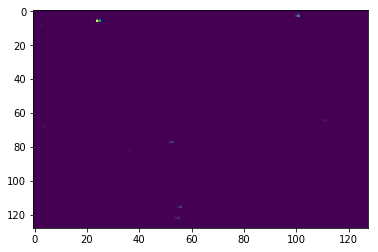

In [13]:
# DEBUG
# Check that the data is not corrupted 

# from tensorflow.examples.tutorials.mnist import input_data
# mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)
# test=mnist.train.next_batch(200)[0]
# type(test)

plt.imshow(data[850].reshape(size),aspect="auto")
plt.show()

# Create a dataset. data.shape should return (X,Y) X being the number of images and Y the number of pixels
data.shape
ds = datasets.Dataset(data)

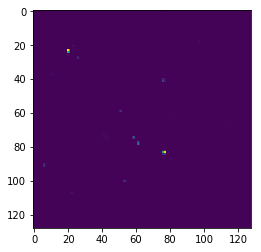

In [15]:
# Plot an image from our dataset object
plt.imshow(ds.X[850].reshape(size))

In [10]:
# Encoder

latent_dim = 64
h_dim = 1000 

# Initialize weights and biases
W_enc = weight_variable([n_pixels, h_dim], 'W_enc')
b_enc = bias_variable([h_dim], 'b_enc')

# tanh activation function from the original model

h_enc = tf.nn.tanh(FC_layer(X, W_enc, b_enc))

# Get mean before calculating the z vector
W_mu = weight_variable([h_dim, latent_dim], 'W_mu')
b_mu = bias_variable([latent_dim], 'b_mu')
mu = FC_layer(h_enc, W_mu, b_mu)

# Get standard deviation before calculating the z vector
W_logstd = weight_variable([h_dim, latent_dim], 'W_logstd')
b_logstd = bias_variable([latent_dim], 'b_logstd')
logstd = FC_layer(h_enc, W_logstd, b_logstd)

# Reparameterization trick

noise = tf.random_normal([1, latent_dim])
z = mu + tf.multiply(noise, tf.exp(.5*logstd))

In [11]:
# Decoder
# Initialize weights and biases
W_dec = weight_variable([latent_dim, h_dim], 'W_dec')
b_dec = bias_variable([h_dim], 'b_dec')
h_dec = tf.nn.tanh(FC_layer(z, W_dec, b_dec))
# Decode back to original dimensionality,i.e., number of pixels
W_reconstruct = weight_variable([h_dim, n_pixels], 'W_reconstruct')
b_reconstruct = bias_variable([n_pixels], 'b_reconstruct')
reconstruction = tf.nn.sigmoid(FC_layer(h_dec, W_reconstruct, b_reconstruct))

In [10]:
# Loss function

log_likelihood = tf.reduce_sum(X*tf.log(reconstruction + 1e-9)+(1 - X)*tf.log(1 - reconstruction + 1e-9), reduction_indices=1)
KL_term = -.5 * tf.reduce_sum(1 + 2*logstd - tf.pow(mu,2) - tf.exp(2*logstd), reduction_indices=1)
variational_lower_bound = tf.reduce_mean(log_likelihood - KL_term)
optimizer = tf.train.AdadeltaOptimizer().minimize(-variational_lower_bound)

In [16]:
# Training

init = tf.global_variables_initializer()
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
sess.run(init)
saver = tf.train.Saver()

In [17]:
# Visualize TensorBoard

from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

show_graph(tf.get_default_graph().as_graph_def())

In [ ]:
import time
# Start training
batch_size = 64
num_iterations = 10000
recording_interval = 100
# Arrays for plotting these values later
variational_lower_bound_array = []
log_likelihood_array = []
KL_term_array = []
for i in range(num_iterations):
    # Batch training
    for x_batch, _ in ds.train.next_batch(batch_size = batch_size):
        sess.run(optimizer, feed_dict={X: x_batch})
        if (i%recording_interval == 0):
            vlb_eval = variational_lower_bound.eval(feed_dict={X: x_batch})
            print("Iteration: {}, Loss: {}".format(i,vlb_eval))
            variational_lower_bound_array.append(vlb_eval)
            log_likelihood_array.append(np.mean(log_likelihood.eval(feed_dict={X: x_batch})))
            KL_term_array.append(np.mean(KL_term.eval(feed_dict={X: x_batch})))

Iteration: 0, Loss: -1085107.5
Iteration: 0, Loss: -3024288.75
Iteration: 0, Loss: -372375.40625
Iteration: 0, Loss: -13566818.0
Iteration: 0, Loss: -1308223.75
Iteration: 0, Loss: -23473698.0
Iteration: 0, Loss: -577001.75
Iteration: 0, Loss: -6442543.0
Iteration: 0, Loss: -528169.625
Iteration: 0, Loss: -841587.875
Iteration: 0, Loss: -7000377.5
Iteration: 0, Loss: -1186477.875
Iteration: 0, Loss: -543209.1875
Iteration: 0, Loss: -789922.0
Iteration: 0, Loss: -15862334.0
Iteration: 0, Loss: -801608.25
Iteration: 0, Loss: -614137.625
Iteration: 0, Loss: -1242970.0
Iteration: 0, Loss: -809608.25
Iteration: 0, Loss: -3548753.75
Iteration: 0, Loss: -474750.6875
Iteration: 0, Loss: -505316.53125
Iteration: 0, Loss: -668957.0
Iteration: 0, Loss: -1336513.0
Iteration: 0, Loss: -597951.875
Iteration: 0, Loss: -898441.8125
Iteration: 0, Loss: -1811381.25
Iteration: 0, Loss: -4051018.5
Iteration: 0, Loss: -12914224.0
Iteration: 0, Loss: -741439.25
Iteration: 0, Loss: -983767.0
Iteration: 0, Lo

Iteration: 600, Loss: -2590004.5
Iteration: 600, Loss: -43971.5078125
Iteration: 600, Loss: -38518.51953125
Iteration: 700, Loss: -58909.53515625
Iteration: 700, Loss: -93640.125
Iteration: 700, Loss: -91604.5
Iteration: 700, Loss: -40722.53125
Iteration: 700, Loss: -22389.240234375
Iteration: 700, Loss: -193340.5625
Iteration: 700, Loss: -47103.41015625
Iteration: 700, Loss: -102665.109375
Iteration: 700, Loss: -40813.5
Iteration: 700, Loss: -65363.43359375
Iteration: 700, Loss: -31353.513671875
Iteration: 700, Loss: -30808.69921875
Iteration: 700, Loss: -55139.80859375
Iteration: 700, Loss: -45484.51171875
Iteration: 700, Loss: -1965452.0
Iteration: 700, Loss: -75325.4140625
Iteration: 700, Loss: -76454.609375
Iteration: 700, Loss: -171160.09375
Iteration: 700, Loss: -727883.375
Iteration: 700, Loss: -201791.515625
Iteration: 700, Loss: -58796.25
Iteration: 700, Loss: -214579.46875
Iteration: 700, Loss: -425763.5
Iteration: 700, Loss: -39819.15234375
Iteration: 700, Loss: -380235.062

Iteration: 1300, Loss: -6882.52978515625
Iteration: 1300, Loss: -12632.552734375
Iteration: 1300, Loss: -23376.4140625
Iteration: 1300, Loss: -34618.953125
Iteration: 1300, Loss: -16879.3359375
Iteration: 1300, Loss: -7616.4501953125
Iteration: 1300, Loss: -13014.111328125
Iteration: 1300, Loss: -14207.380859375
Iteration: 1300, Loss: -3482.73974609375
Iteration: 1300, Loss: -16626.287109375
Iteration: 1300, Loss: -7351.37060546875
Iteration: 1300, Loss: -14393.6171875
Iteration: 1300, Loss: -16960.447265625
Iteration: 1300, Loss: -39473.53125
Iteration: 1300, Loss: -160673.203125
Iteration: 1300, Loss: -20755.798828125
Iteration: 1300, Loss: -707.953857421875
Iteration: 1300, Loss: -24006.77734375
Iteration: 1300, Loss: -15344.4150390625
Iteration: 1300, Loss: -406727.15625
Iteration: 1300, Loss: -5963.73486328125
Iteration: 1300, Loss: -6834.62548828125
Iteration: 1300, Loss: -14547.966796875
Iteration: 1400, Loss: -6675.0556640625
Iteration: 1400, Loss: -20464.94140625
Iteration: 14

Iteration: 1900, Loss: 1824.087890625
Iteration: 1900, Loss: 9788.2890625
Iteration: 1900, Loss: 7339.8916015625
Iteration: 1900, Loss: -11041.05859375
Iteration: 1900, Loss: -3453.8701171875
Iteration: 1900, Loss: 16669.3515625
Iteration: 1900, Loss: 10597.87890625
Iteration: 1900, Loss: 5652.17041015625
Iteration: 1900, Loss: 11361.3212890625
Iteration: 1900, Loss: 16516.767578125
Iteration: 1900, Loss: 20549.82421875
Iteration: 1900, Loss: -3031.15576171875
Iteration: 1900, Loss: 11414.7763671875
Iteration: 1900, Loss: 1421.960205078125
Iteration: 1900, Loss: -1661.0908203125
Iteration: 1900, Loss: 706.91455078125
Iteration: 1900, Loss: 18274.138671875
Iteration: 1900, Loss: -2515.2529296875
Iteration: 2000, Loss: 13381.6591796875
Iteration: 2000, Loss: 13864.0693359375
Iteration: 2000, Loss: -1865.692626953125
Iteration: 2000, Loss: -22557.21875
Iteration: 2000, Loss: 17764.17578125
Iteration: 2000, Loss: 1886.771728515625
Iteration: 2000, Loss: 28958.49609375
Iteration: 2000, Loss

Iteration: 2500, Loss: 24402.650390625
Iteration: 2500, Loss: 8975.8349609375
Iteration: 2500, Loss: 24325.546875
Iteration: 2500, Loss: 20727.99609375
Iteration: 2500, Loss: 34228.84375
Iteration: 2500, Loss: 8673.0458984375
Iteration: 2500, Loss: 8821.9873046875
Iteration: 2500, Loss: 19544.328125
Iteration: 2600, Loss: 22968.73828125
Iteration: 2600, Loss: 21763.078125
Iteration: 2600, Loss: 8551.0546875
Iteration: 2600, Loss: -3180.51904296875
Iteration: 2600, Loss: 22439.90234375
Iteration: 2600, Loss: 7675.8037109375
Iteration: 2600, Loss: 36188.375
Iteration: 2600, Loss: 31050.75390625
Iteration: 2600, Loss: 17232.80859375
Iteration: 2600, Loss: 22782.28515625
Iteration: 2600, Loss: 12670.0966796875
Iteration: 2600, Loss: 9583.978515625
Iteration: 2600, Loss: 16000.6826171875
Iteration: 2600, Loss: 9860.6630859375
Iteration: 2600, Loss: 8586.064453125
Iteration: 2600, Loss: 11983.7373046875
Iteration: 2600, Loss: 32406.115234375
Iteration: 2600, Loss: 5451.78662109375
Iteration:

Iteration: 4500, Loss: 35592.55078125
Iteration: 4500, Loss: 23214.654296875
Iteration: 4500, Loss: 9814.2900390625
Iteration: 4500, Loss: 36638.5078125
Iteration: 4500, Loss: 14744.578125
Iteration: 4500, Loss: 33053.0390625
Iteration: 4500, Loss: 14447.84375
Iteration: 4500, Loss: 10536.9609375
Iteration: 4500, Loss: 17587.40234375
Iteration: 4500, Loss: 64239.98828125
Iteration: 4500, Loss: 11417.6044921875
Iteration: 4500, Loss: 12529.78515625
Iteration: 4500, Loss: 54657.296875
Iteration: 4500, Loss: 34549.6015625
Iteration: 4500, Loss: 44264.96484375
Iteration: 4500, Loss: 18431.349609375
Iteration: 4500, Loss: 27078.1328125
Iteration: 4500, Loss: 1988.98095703125
Iteration: 4500, Loss: 19710.99609375
Iteration: 4500, Loss: 23698.076171875
Iteration: 4500, Loss: 14296.986328125
Iteration: 4500, Loss: 25645.94921875
Iteration: 4500, Loss: 13765.21875
Iteration: 4500, Loss: 28998.142578125
Iteration: 4500, Loss: 52772.703125
Iteration: 4500, Loss: 22249.822265625
Iteration: 4500, L

Iteration: 5100, Loss: 41124.55078125
Iteration: 5100, Loss: 29382.490234375
Iteration: 5100, Loss: 23412.56640625
Iteration: 5100, Loss: 24049.853515625
Iteration: 5100, Loss: 30440.380859375
Iteration: 5100, Loss: 51795.7734375
Iteration: 5100, Loss: 17859.01953125
Iteration: 5100, Loss: 29853.056640625
Iteration: 5100, Loss: 29339.505859375
Iteration: 5100, Loss: 14189.2529296875
Iteration: 5100, Loss: 8569.5283203125
Iteration: 5100, Loss: 37678.5703125
Iteration: 5100, Loss: 25585.78125
Iteration: 5100, Loss: 22721.47265625
Iteration: 5100, Loss: 18530.998046875
Iteration: 5100, Loss: 35223.30078125
Iteration: 5200, Loss: 35192.05859375
Iteration: 5200, Loss: 19040.470703125
Iteration: 5200, Loss: 18645.240234375
Iteration: 5200, Loss: 25511.78125
Iteration: 5200, Loss: 45376.734375
Iteration: 5200, Loss: 19051.677734375
Iteration: 5200, Loss: 44818.0625
Iteration: 5200, Loss: 18141.68359375
Iteration: 5200, Loss: 19535.265625
Iteration: 5200, Loss: 35053.68359375
Iteration: 5200,

Iteration: 8200, Loss: 37866.296875
Iteration: 8200, Loss: 29283.341796875
Iteration: 8300, Loss: 20695.97265625
Iteration: 8300, Loss: 21826.4140625
Iteration: 8300, Loss: 10336.6650390625
Iteration: 8300, Loss: 31746.8125
Iteration: 8300, Loss: 20829.044921875
Iteration: 8300, Loss: 17220.13671875
Iteration: 8300, Loss: 36775.7890625
Iteration: 8300, Loss: 31842.1953125
Iteration: 8300, Loss: 15267.435546875
Iteration: 8300, Loss: 24873.990234375
Iteration: 8300, Loss: 43023.48046875
Iteration: 8300, Loss: 26993.01171875
Iteration: 8300, Loss: 10688.166015625
Iteration: 8300, Loss: 32154.42578125
Iteration: 8300, Loss: 26916.703125
Iteration: 8300, Loss: 40706.0546875
Iteration: 8300, Loss: 11829.94921875
Iteration: 8300, Loss: 26222.072265625
Iteration: 8300, Loss: 21685.7109375
Iteration: 8300, Loss: 15167.8134765625
Iteration: 8300, Loss: 42789.765625
Iteration: 8300, Loss: 39428.55859375
Iteration: 8300, Loss: 19713.73046875
Iteration: 8300, Loss: 48415.5
Iteration: 8300, Loss: 2

Iteration: 8900, Loss: 29753.998046875
Iteration: 8900, Loss: 43336.41015625
Iteration: 8900, Loss: 43154.484375
Iteration: 8900, Loss: 47576.703125
Iteration: 8900, Loss: 36607.0
Iteration: 8900, Loss: 16047.5791015625
Iteration: 8900, Loss: 15569.1455078125
Iteration: 8900, Loss: 26959.83984375
Iteration: 8900, Loss: 32673.44140625
Iteration: 8900, Loss: 36910.4140625
Iteration: 8900, Loss: 22286.19140625
Iteration: 8900, Loss: 43408.0703125
Iteration: 8900, Loss: 26913.796875
Iteration: 8900, Loss: 16463.05078125
Iteration: 8900, Loss: 27709.609375
Iteration: 8900, Loss: 22154.083984375
Iteration: 8900, Loss: 54873.828125
Iteration: 8900, Loss: 17219.85546875
Iteration: 8900, Loss: 43302.68359375
Iteration: 8900, Loss: 31833.390625
Iteration: 8900, Loss: 31681.2109375
Iteration: 8900, Loss: 17142.673828125
Iteration: 9000, Loss: 31489.4140625
Iteration: 9000, Loss: 47565.296875
Iteration: 9000, Loss: 15876.8125
Iteration: 9000, Loss: 38310.21875
Iteration: 9000, Loss: 27525.85742187

Iteration: 9500, Loss: 25908.66796875
Iteration: 9500, Loss: 26526.08984375
Iteration: 9500, Loss: 22911.326171875
Iteration: 9500, Loss: 48342.5234375
Iteration: 9500, Loss: 47747.03125
Iteration: 9500, Loss: 70330.609375
Iteration: 9600, Loss: 36514.05078125
Iteration: 9600, Loss: 17618.55859375
Iteration: 9600, Loss: 41948.59375
Iteration: 9600, Loss: 31298.572265625
Iteration: 9600, Loss: 26646.55859375
Iteration: 9600, Loss: 48308.26171875
Iteration: 9600, Loss: 26412.56640625
Iteration: 9600, Loss: 35791.97265625
Iteration: 9600, Loss: 25856.294921875
Iteration: 9600, Loss: 22194.345703125
Iteration: 9600, Loss: 22860.318359375
Iteration: 9600, Loss: 4776.62158203125
Iteration: 9600, Loss: 21365.927734375
Iteration: 9600, Loss: 23416.404296875
Iteration: 9600, Loss: 32463.607421875
Iteration: 9600, Loss: 38406.21875
Iteration: 9600, Loss: 37717.78125
Iteration: 9600, Loss: 36093.953125
Iteration: 9600, Loss: 38046.75
Iteration: 9600, Loss: 33030.40625
Iteration: 9600, Loss: 27191

In [14]:
# Save model
saver.save(sess, '1kVAE29June30-2kImages', global_step=recording_interval, write_meta_graph=False)

'1kVAE29June30-2kImages-100'

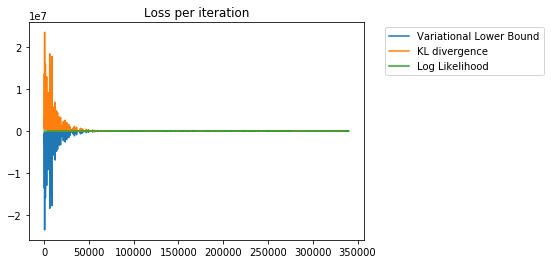

In [16]:
#len(KL_term_array)
iteration_array = [i*recording_interval for i in range(3400)]
plt.figure()
plt.plot(iteration_array, variational_lower_bound_array)
plt.plot(iteration_array, KL_term_array)
plt.plot(iteration_array, log_likelihood_array)
plt.legend(['Variational Lower Bound', 'KL divergence', 'Log Likelihood'], bbox_to_anchor=(1.05, 1), loc=2)
plt.title('Loss per iteration')
plt.savefig('loss_graph.png', bbox_inches='tight')

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


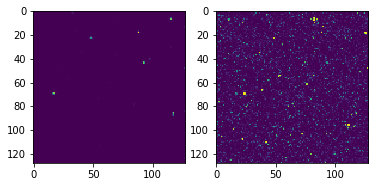

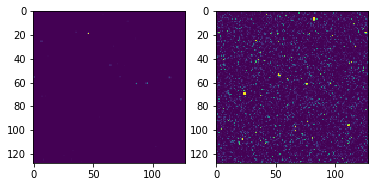

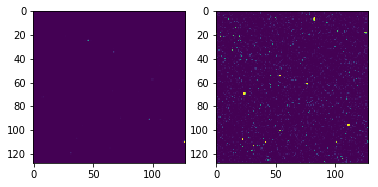

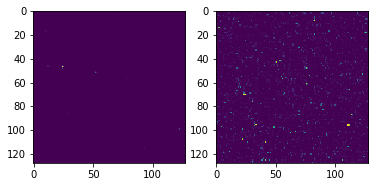

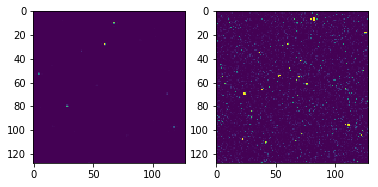

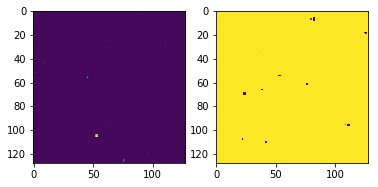

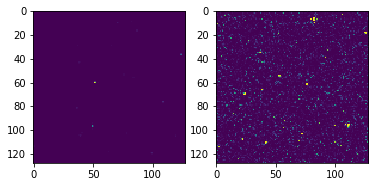

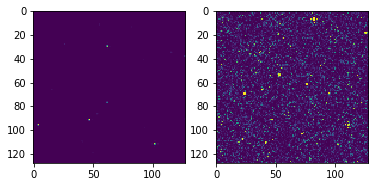

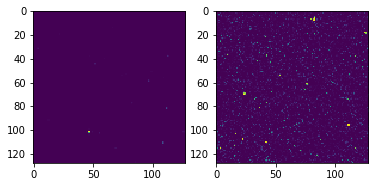

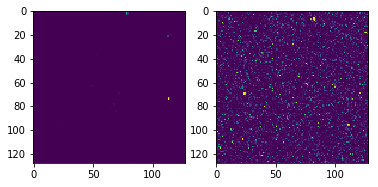

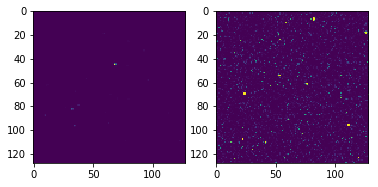

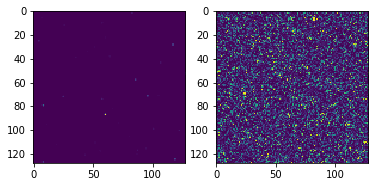

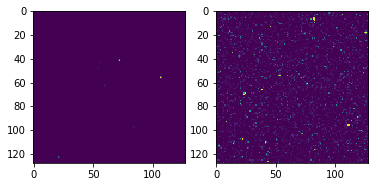

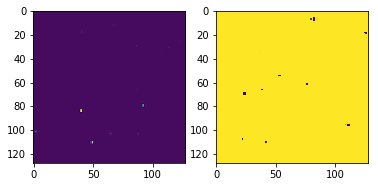

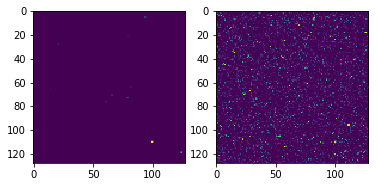

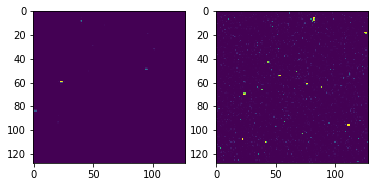

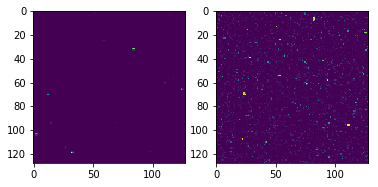

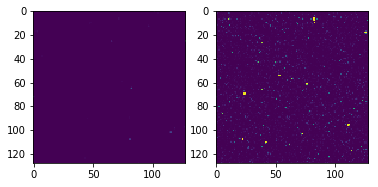

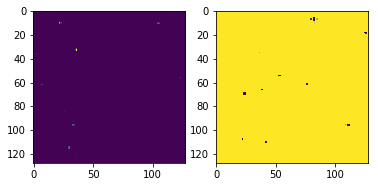

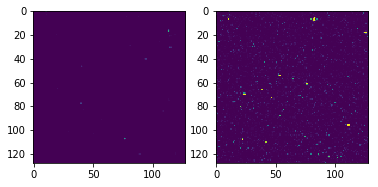

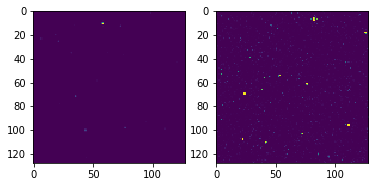

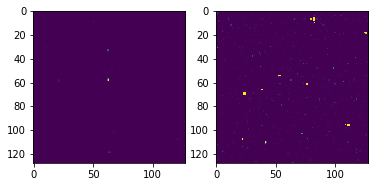

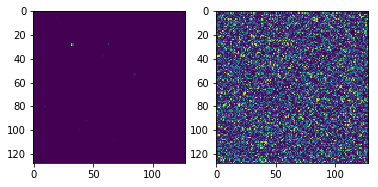

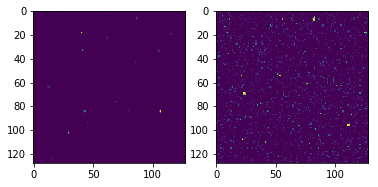

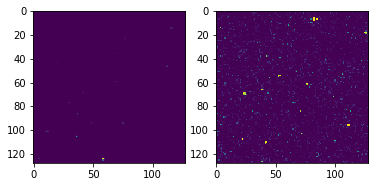

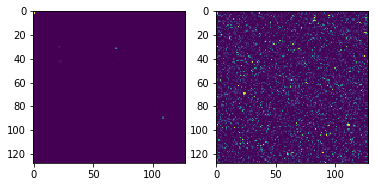

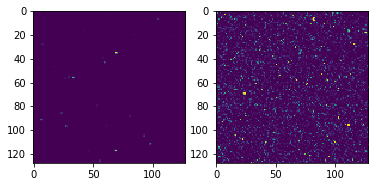

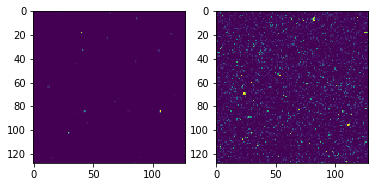

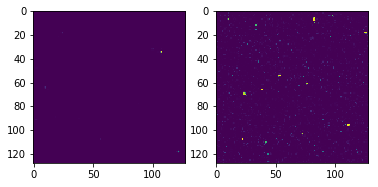

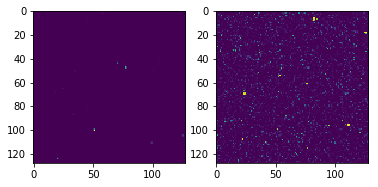

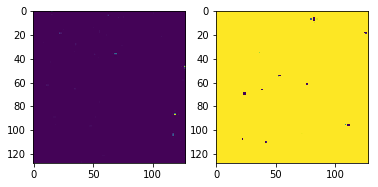

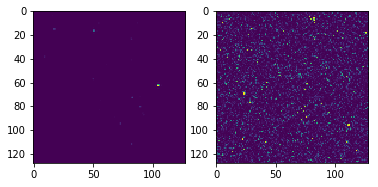

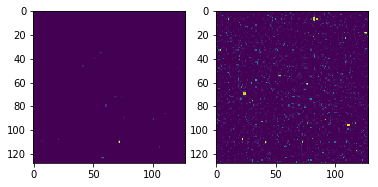

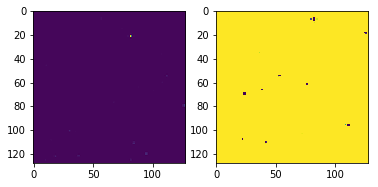

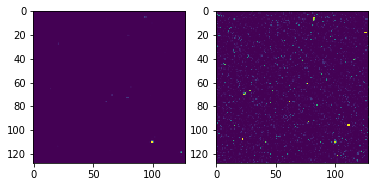

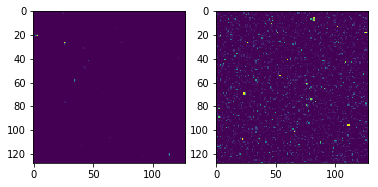

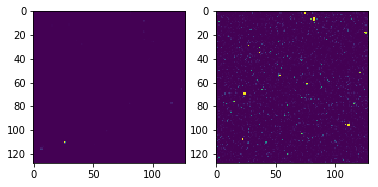

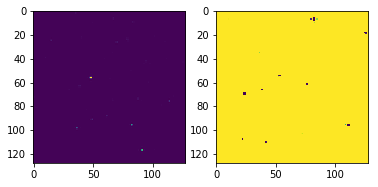

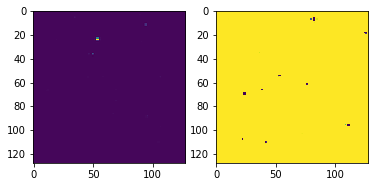

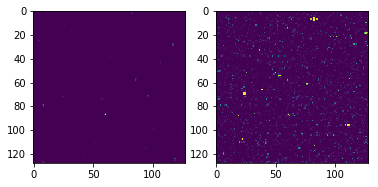

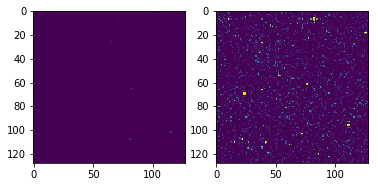

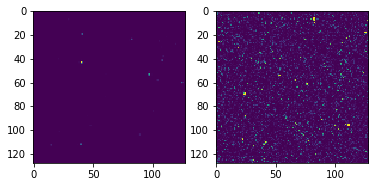

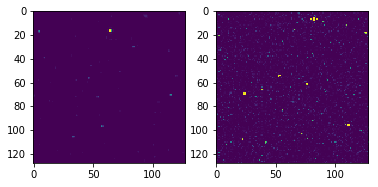

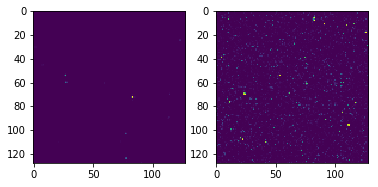

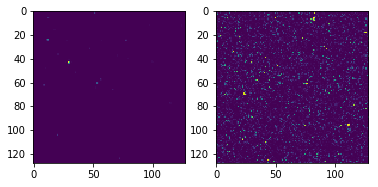

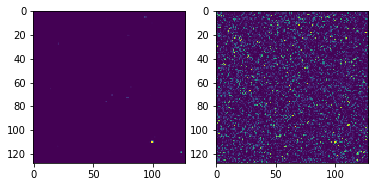

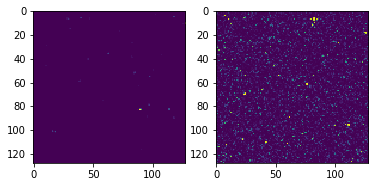

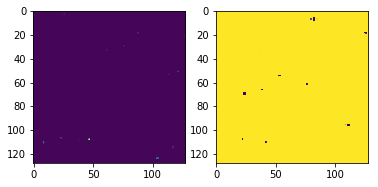

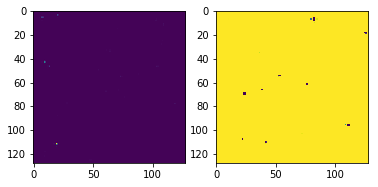

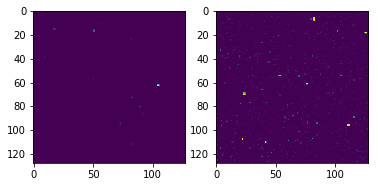

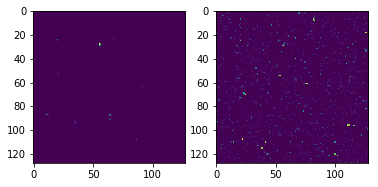

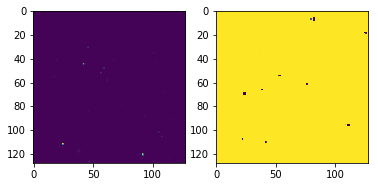

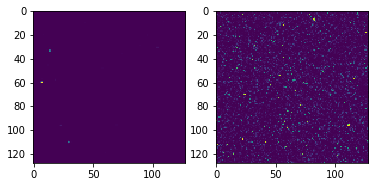

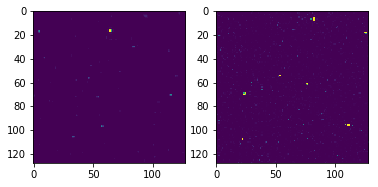

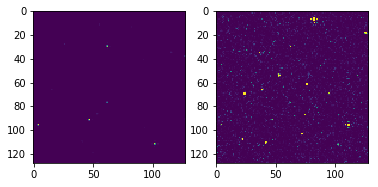

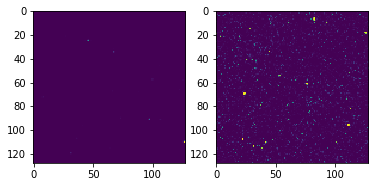

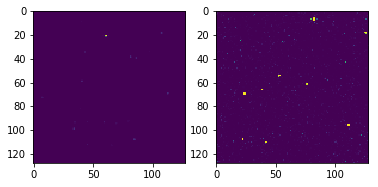

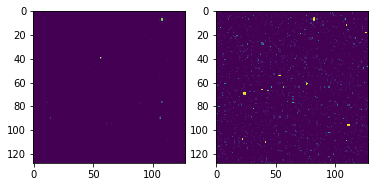

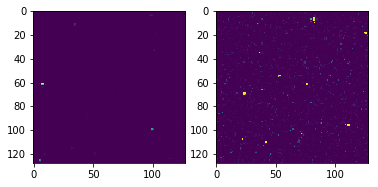

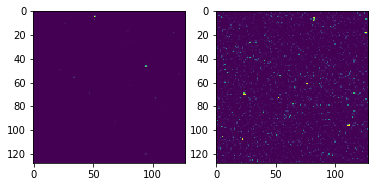

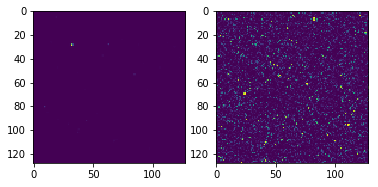

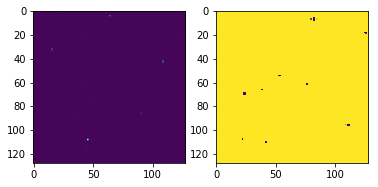

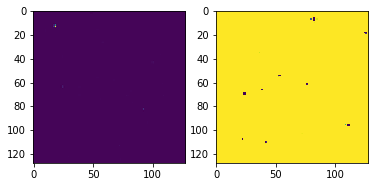

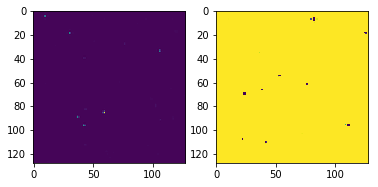

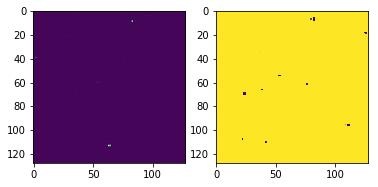

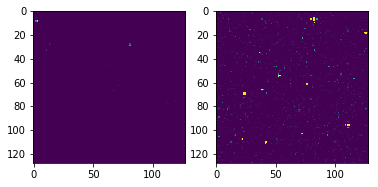

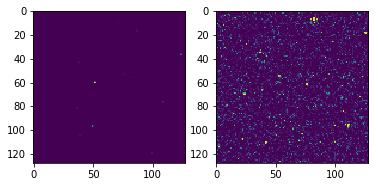

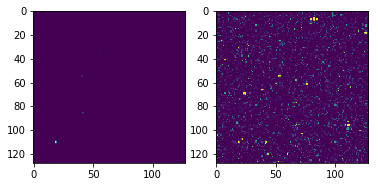

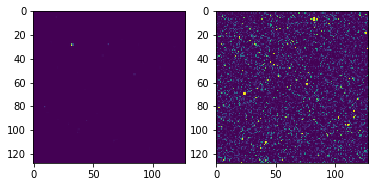

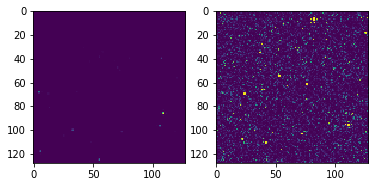

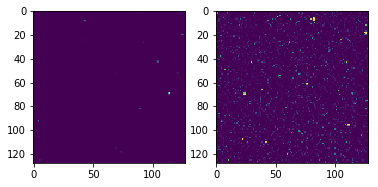

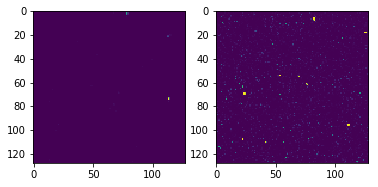

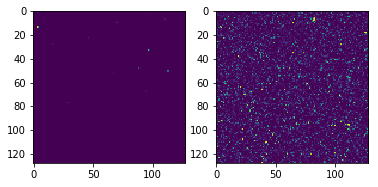

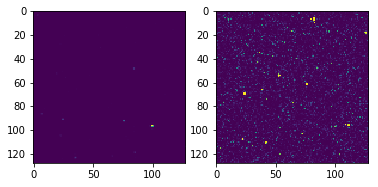

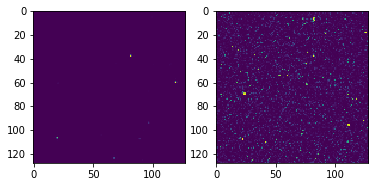

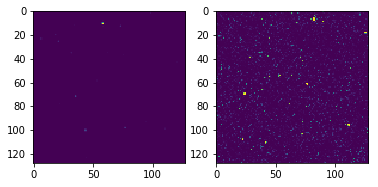

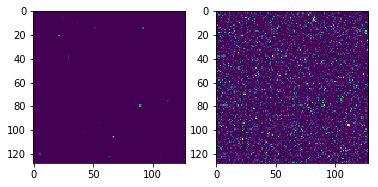

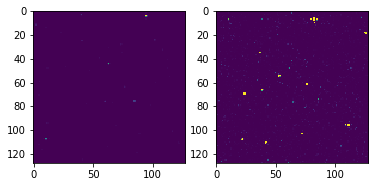

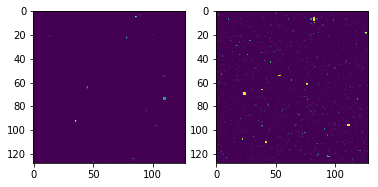

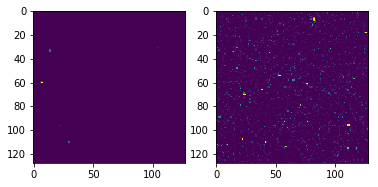

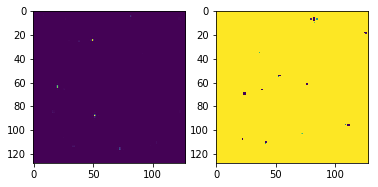

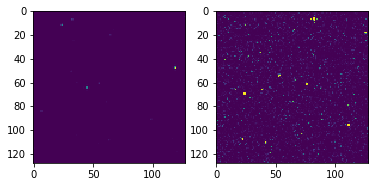

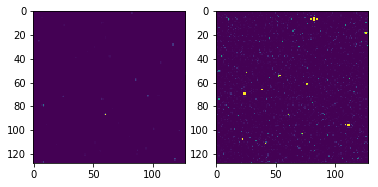

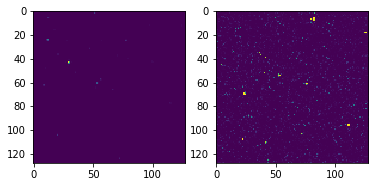

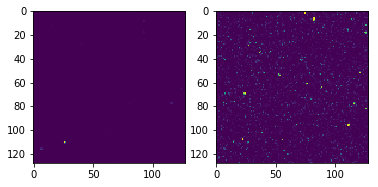

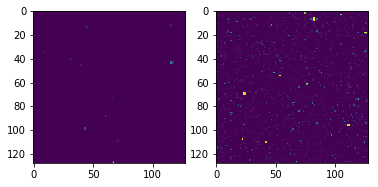

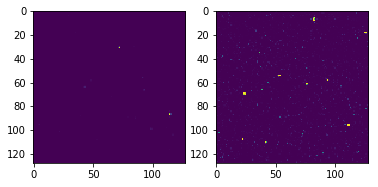

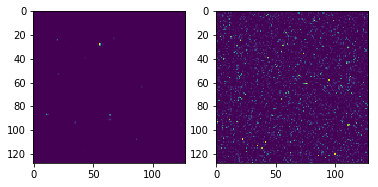

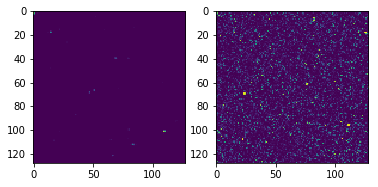

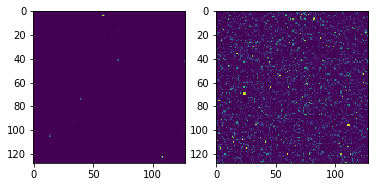

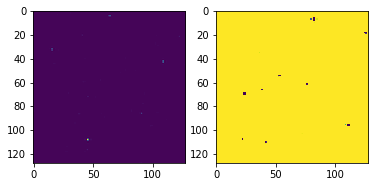

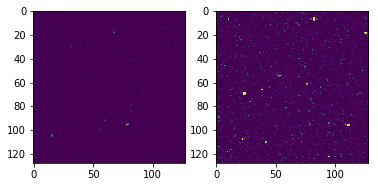

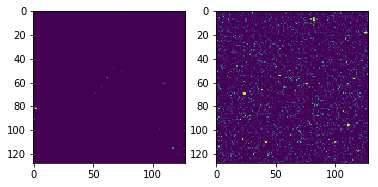

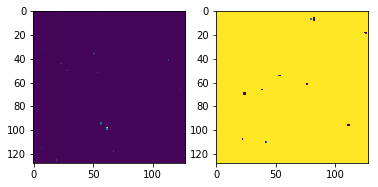

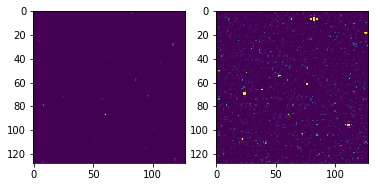

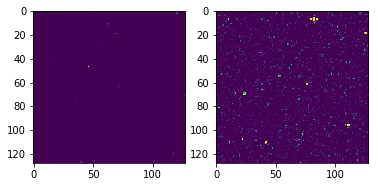

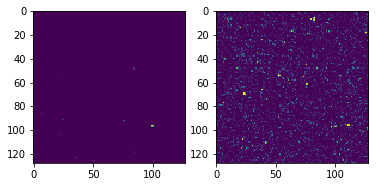

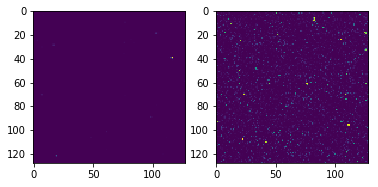

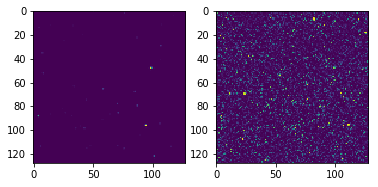

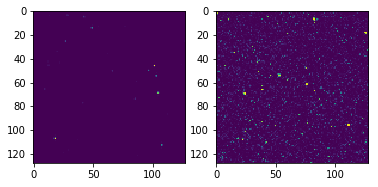

In [18]:
#batch size 64, latent dim 64, h dim 1000, 10k iterations, 2000 images, interval 100
import scipy.misc
num_pairs = 100
image_indices = np.random.randint(0, 200, num_pairs)
for pair in range(num_pairs):
    x = np.reshape(data[image_indices[pair]], (1,n_pixels))
    plt.figure()
    x_image = np.reshape(x, (size))
    plt.subplot(121)
    plt.imshow(x_image)
    x_reconstruction = reconstruction.eval(feed_dict={X: x})
    x_reconstruction_image = (np.reshape(x_reconstruction, (size)))
    #plt.imsave("/home/intergalactic/Prashanth/batch_output/{}.png".format(pair),x_reconstruction_image)
    plt.subplot(122) 
    plt.imshow(x_reconstruction_image)
    scipy.misc.imsave("/home/intergalactic/Prashanth/batch_output/{}.png".format(pair), x_reconstruction_image)


In [20]:
print(sess.run(z,feed_dict={X: [ds.X[1]]}))

[[ 1.0926851  -0.96093428  0.50679851  1.32651997  2.74217701 -1.48260093
  -0.08129618 -0.4874354   0.61635399 -2.08678889  1.1641469  -2.65805483
   1.58666611  0.07776421  0.79077053  1.60911167 -4.28404903  2.78153205
  -1.99560201 -0.83569169  1.87596655  1.76225519 -1.92810655  0.89633691
  -0.49932429 -0.05192113 -2.48719501 -1.01855052  2.31367922  2.94923019
  -2.52566552 -0.47220233  2.97162962 -1.47964942 -0.31658146 -1.68685305
  -0.61325014 -1.10735846  1.88967335  2.16891074 -2.68156099  0.53564894
  -2.42532992 -1.35075152  1.62139487 -0.46771848  1.82784522 -2.05661964
   1.41738176  0.91092747 -0.7252112  -3.05470705  0.19997323  0.78468823
  -2.58702374  1.42357397  0.37867558  1.66662621  2.81577587  4.19393015
  -0.38656467 -0.34500754 -0.54552162  1.69168937]]
